In [1]:
# Cell 1: Installations
!pip install torch torchvision matplotlib
!nvidia-smi  # Check GPU availability

zsh:1: command not found: nvidia-smi


In [2]:
# Cell 2: Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display

In [3]:
# Cell 3: Dataset Configuration
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Range [-1, 1]
])

In [4]:
# Cell 4: Data Loading
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

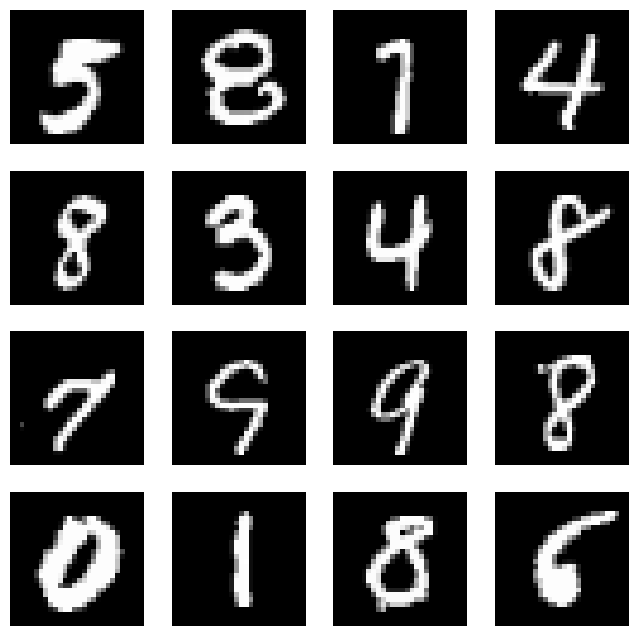

In [5]:
# Cell 5: Data Visualization
def show_images(images):
    plt.figure(figsize=(8,8))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i][0], cmap='gray')
        plt.axis('off')
    plt.show()

real_batch = next(iter(train_loader))
show_images(real_batch[0])

In [6]:
# Cell 6: Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [7]:
# Cell 7: Discriminator Network        
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [8]:
# Cell 8: Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# Cell 9: Create Models
generator = Generator().to(device)
discriminator = Discriminator().to(device)


In [10]:
# Cell 10: Optimizers
lr = 0.0002
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [11]:
# Cell 11: Training Parameters
num_epochs = 2
latent_dim = 100
loss_fn = nn.BCELoss()


In [12]:
# Cell 12: Training Progress Display
def show_generated(generator, latent_dim):
    z = torch.randn(16, latent_dim).to(device)
    gen_imgs = generator(z).detach().cpu()
    show_images(gen_imgs)

Epoch [0/2] | d_loss: 0.3691 | g_loss: 1.9373


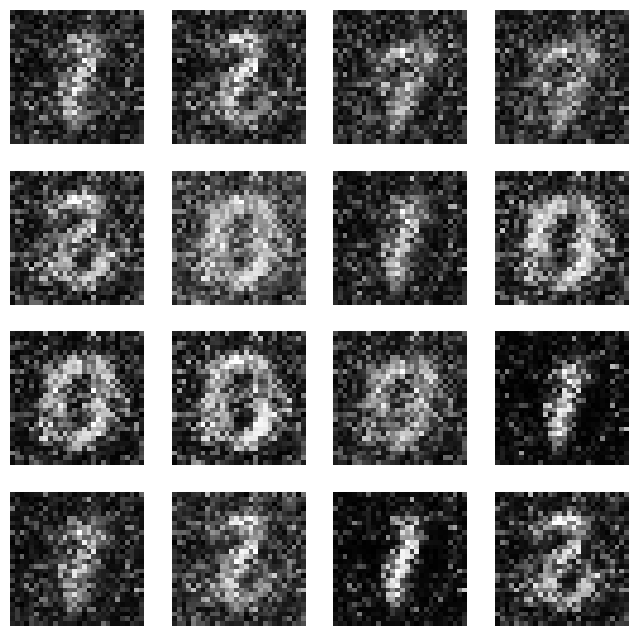

In [13]:
# Cell 13: Main Training Loop
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(train_loader):
        # Configure input
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Real images
        real_labels = torch.ones(batch_size, 1).to(device)
        real_preds = discriminator(real_imgs)
        d_loss_real = loss_fn(real_preds, real_labels)
        
        # Fake images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = generator(z)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        fake_preds = discriminator(fake_imgs.detach())
        d_loss_fake = loss_fn(fake_preds, fake_labels)
        
        # Total loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Generate images
        gen_imgs = generator(z)
        g_preds = discriminator(gen_imgs)
        g_loss = loss_fn(g_preds, real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        # Save losses
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())
    
    # Display progress
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{num_epochs}] | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}")
        show_generated(generator, latent_dim)

In [14]:
# Cell 14: DCGAN Generator
class DCGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, 100, 1, 1)
        return self.main(x)

In [15]:
# Cell 15: DCGAN Discriminator
class DCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.main(x)
        return out.view(out.size(0), -1)

In [16]:
# Cell 16: DCGAN Initialization
dc_generator = DCGenerator().to(device)
dc_discriminator = DCDiscriminator().to(device)

optimizer_G = optim.Adam(dc_generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(dc_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Starting DCGAN training...
Epoch [0/2] Batch [0/469] D_loss: 0.6908 G_loss: 1.3191
Epoch [0/2] Batch [100/469] D_loss: 0.0017 G_loss: 6.5028
Epoch [0/2] Batch [200/469] D_loss: 0.0005 G_loss: 7.5047
Epoch [0/2] Batch [300/469] D_loss: 0.0004 G_loss: 7.7521
Epoch [0/2] Batch [400/469] D_loss: 0.0003 G_loss: 7.8440
Epoch [0/2] D_loss: 0.0056 G_loss: 7.1841


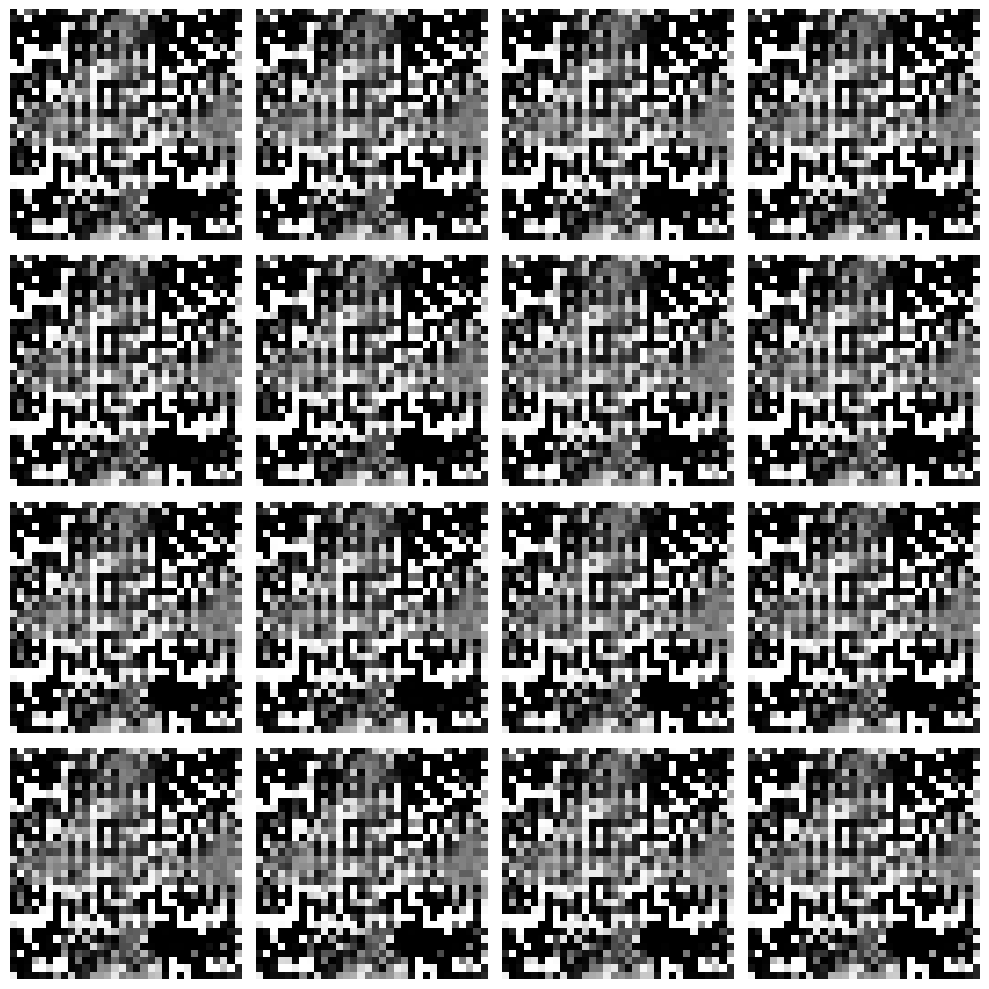

Epoch [1/2] Batch [0/469] D_loss: 0.0002 G_loss: 8.4130
Epoch [1/2] Batch [100/469] D_loss: 0.0001 G_loss: 8.8386
Epoch [1/2] Batch [200/469] D_loss: 0.0001 G_loss: 9.0622
Epoch [1/2] Batch [300/469] D_loss: 0.0001 G_loss: 9.3013
Epoch [1/2] Batch [400/469] D_loss: 0.0001 G_loss: 9.2567
Epoch [1/2] D_loss: 0.0001 G_loss: 9.0599


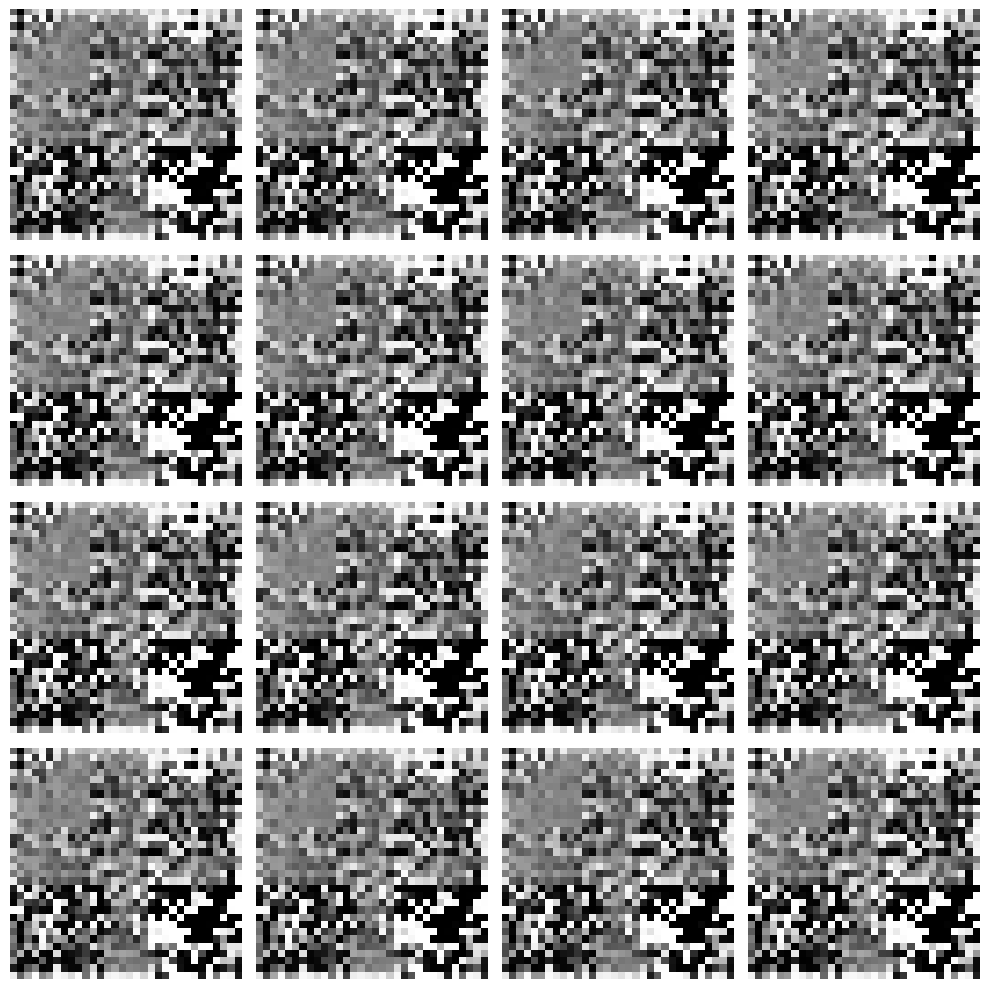

Training complete!


In [17]:
# Cell 17: DCGAN Training Loop with Progress Tracking
G_losses = []
D_losses = []

print("Starting DCGAN training...")
for epoch in range(num_epochs):
    epoch_g_losses = []
    epoch_d_losses = []
    
    for i, (real_imgs, _) in enumerate(train_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)
        
        # Train D
        optimizer_D.zero_grad()
        
        # Real images
        real_preds = dc_discriminator(real_imgs)
        real_preds = real_preds.view(-1)  # Flatten to 1D
        real_labels = torch.ones_like(real_preds)
        d_loss_real = loss_fn(real_preds, real_labels)
        
        # Fake images
        z = torch.randn(batch_size, 100, 1, 1).to(device)
        fake_imgs = dc_generator(z)
        fake_preds = dc_discriminator(fake_imgs.detach())
        fake_preds = fake_preds.view(-1)  # Flatten to 1D
        fake_labels = torch.zeros_like(fake_preds)
        d_loss_fake = loss_fn(fake_preds, fake_labels)
        
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()
        
        # Train G
        optimizer_G.zero_grad()
        gen_imgs = dc_generator(z)
        g_preds = dc_discriminator(gen_imgs)
        g_preds = g_preds.view(-1)  # Flatten to 1D
        g_labels = torch.ones_like(g_preds)  # Create new labels matching g_preds shape
        g_loss = loss_fn(g_preds, g_labels)
        g_loss.backward()
        optimizer_G.step()
        
        # Store batch losses
        epoch_d_losses.append(d_loss.item())
        epoch_g_losses.append(g_loss.item())
        
        # Print progress for every 100 batches
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch [{i}/{len(train_loader)}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")
    
    # Average losses for the epoch
    avg_d_loss = sum(epoch_d_losses) / len(epoch_d_losses)
    avg_g_loss = sum(epoch_g_losses) / len(epoch_g_losses)
    D_losses.append(avg_d_loss)
    G_losses.append(avg_g_loss)
    
    # Print epoch results
    print(f"Epoch [{epoch}/{num_epochs}] D_loss: {avg_d_loss:.4f} G_loss: {avg_g_loss:.4f}")
    
    # Generate and display images every 5 epochs
    if epoch % 5 == 0 or epoch == num_epochs-1:
        with torch.no_grad():
            z = torch.randn(16, 100, 1, 1).to(device)
            generated_images = dc_generator(z).detach().cpu()
            
            plt.figure(figsize=(10, 10))
            for i in range(16):
                plt.subplot(4, 4, i+1)
                plt.imshow(generated_images[i, 0, :, :].numpy(), cmap='gray')
                plt.axis('off')
            plt.tight_layout()
            plt.show()

print("Training complete!")


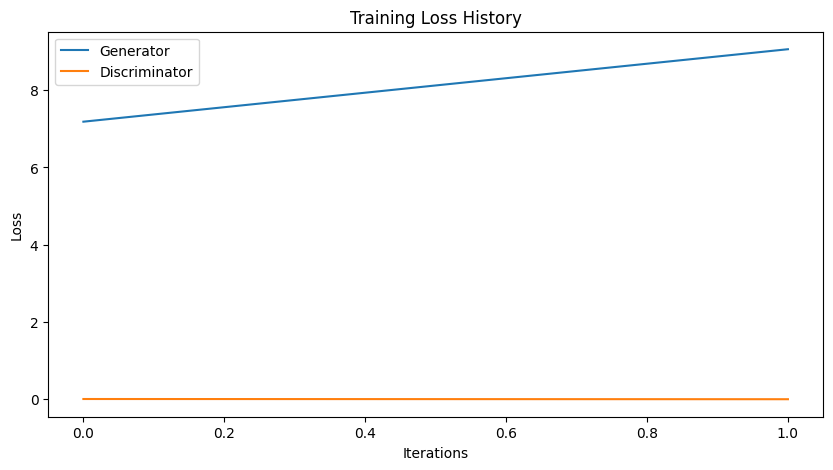

In [18]:
# Cell 18: Loss Visualization
plt.figure(figsize=(10,5))
plt.title("Training Loss History")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Basic GAN Results:


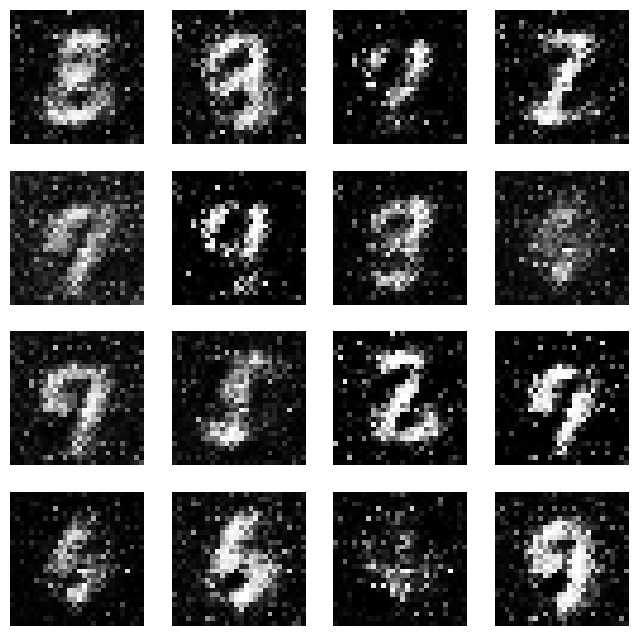

DCGAN Results:


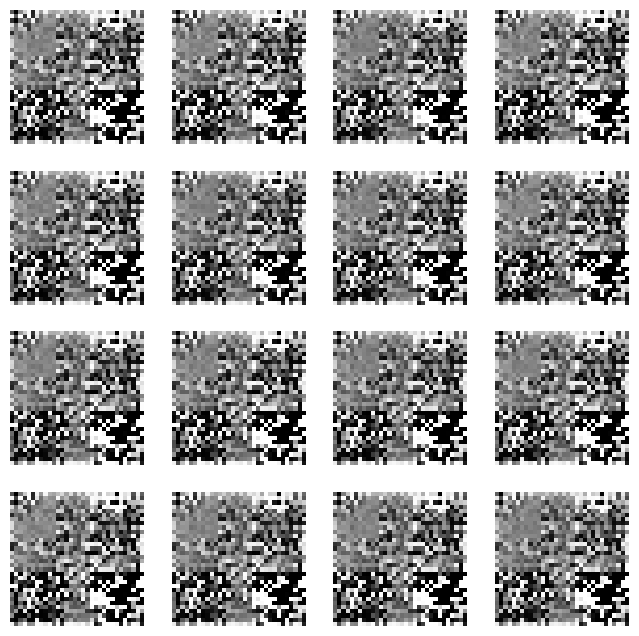

In [19]:
# Cell 19: Final Comparison
print("Basic GAN Results:")
show_generated(generator, 100)

print("DCGAN Results:")
show_generated(dc_generator, 100)

In [20]:
# Cell 20: Model Saving
torch.save(generator.state_dict(), 'gan_generator.pth')
torch.save(dc_generator.state_dict(), 'dcgan_generator.pth')